In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

In [2]:
df1 = pd.read_csv('/Users/msf/Datasets/Flight_Delay_Dataset/Jan_2019_ontime.csv')
df2 = pd.read_csv('/Users/msf/Datasets/Flight_Delay_Dataset/Jan_2020_ontime.csv')

In [3]:
set(df1.columns) == set(df2.columns)

True

In [4]:
df = pd.concat([df1,df2])

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [6]:
df = df[df['DIVERTED'] == 0]
df = df[df['CANCELLED'] == 0]

In [7]:
df = df[['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ORIGIN', 'DEST', 'DISTANCE', 'ARR_DEL15']]

In [8]:
df.dropna()
df = df.reset_index(drop=True)

In [9]:
df = df.rename(columns = {'DAY_OF_WEEK' : 'ON_WEEKEND'})
df['ON_WEEKEND'] = (df['ON_WEEKEND'] > 5).astype(int)

In [10]:
carrier_df = df[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby('OP_UNIQUE_CARRIER').sum().sort_values(by='ARR_DEL15',ascending=False)
carrier_df['CARRIER_cat'] = pd.qcut(carrier_df['ARR_DEL15'], 17, labels = False)
carrier_df

,ARR_DEL15,CARRIER_cat
OP_UNIQUE_CARRIER,,
WN,26432.0,16
AA,25089.0,15
OO,24716.0,14
DL,17862.0,13
UA,15391.0,12
MQ,10823.0,11
B6,10104.0,10
YX,9292.0,9
OH,8641.0,8


In [11]:
data_carrier = carrier_df.loc[df['OP_UNIQUE_CARRIER']].reset_index()
df['CARRIER_cat'] = data_carrier['CARRIER_cat']

In [12]:
time_blk_df = df[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk_df['TIME_cat'] = pd.qcut(time_blk_df['ARR_DEL15'], 19, labels = False)
time_blk_df

,ARR_DEL15,TIME_cat
DEP_TIME_BLK,,
1700-1759,14875.0,18
1800-1859,14020.0,17
1600-1659,13292.0,16
1500-1559,12760.0,15
1900-1959,12640.0,14
1400-1459,12618.0,13
1200-1259,11761.0,12
1100-1159,11181.0,11
1300-1359,11101.0,10


In [13]:
data_time = time_blk_df.loc[df['DEP_TIME_BLK']].reset_index()
df['DEP_TIME_cat'] = data_time['TIME_cat']

In [14]:
origin_df = df[['ORIGIN','ARR_DEL15']].groupby('ORIGIN').sum().sort_values(by='ARR_DEL15',ascending=False)
origin_df['ORIGIN_cat'] = pd.qcut(origin_df['ARR_DEL15'], 25, labels = False)
origin_df

,ARR_DEL15,ORIGIN_cat
ORIGIN,,
ORD,12342.0,24
DFW,8802.0,24
ATL,7271.0,24
CLT,6622.0,24
DEN,5987.0,24
...,...,...
OWB,5.0,0
LWS,4.0,0
PPG,3.0,0


In [15]:
data_origin = origin_df.loc[df['ORIGIN']].reset_index()
df['ORIGIN_cat'] = data_origin['ORIGIN_cat']

In [16]:
dest_df = df[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
dest_df['DEST_cat'] = pd.qcut(dest_df['ARR_DEL15'], 25, labels = False)
dest_df

,ARR_DEL15,DEST_cat
DEST,,
ORD,10170.0,24
DFW,8667.0,24
ATL,7263.0,24
LGA,7077.0,24
SFO,6114.0,24
...,...,...
OWB,3.0,0
ATY,3.0,0
ADK,3.0,0


In [17]:
data_dest = dest_df.loc[df['DEST']].reset_index()
df['DEST_cat'] = data_dest['DEST_cat']

In [18]:
df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15']]
df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,DISTANCE,ARR_DEL15
0,0,6,4,14,24,300.0,0.0
1,0,6,13,23,22,596.0,0.0
2,0,6,12,24,22,229.0,0.0
3,0,6,15,15,24,223.0,0.0
4,0,6,14,24,9,579.0,0.0
...,...,...,...,...,...,...,...
1165226,0,6,5,19,23,443.0,1.0
1165227,0,6,18,24,23,509.0,0.0
1165228,0,6,4,19,24,610.0,0.0
1165229,0,6,18,24,18,589.0,0.0


In [32]:
df_X = df.drop('ARR_DEL15', axis=1)
df_y =  df[['ARR_DEL15']]

In [33]:
X = df_X.values
y = df_y.values

In [34]:
y = LabelBinarizer().fit_transform(y)

In [35]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [36]:
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [38]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)

In [39]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [40]:
print(confusion_matrix(y_test, y_pred_test))

[[145229  50410]
 [ 47772 147679]]


In [41]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77    782085
           1       0.77      0.78      0.78    782273

    accuracy                           0.78   1564358
   macro avg       0.78      0.78      0.78   1564358
weighted avg       0.78      0.78      0.78   1564358



In [42]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75    195639
           1       0.75      0.76      0.75    195451

    accuracy                           0.75    391090
   macro avg       0.75      0.75      0.75    391090
weighted avg       0.75      0.75      0.75    391090



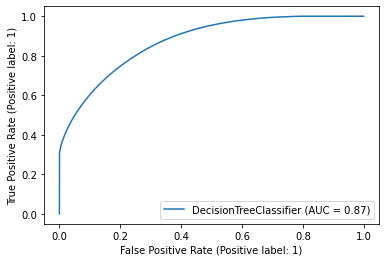

In [43]:
plot_roc_curve(model, X_train, y_train)

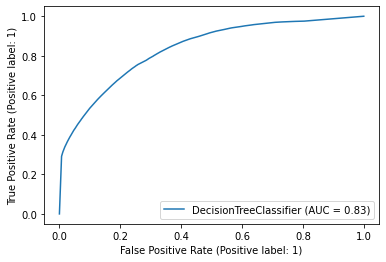

In [44]:
plot_roc_curve(model, X_test, y_test)